In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import math
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !unzip /content/drive/MyDrive/Processed_asl_alphabet.zip -d /content/Datasets

In [4]:
# Paths to training and test data
# train_dir = "/content/Datasets/Processed_asl_alphabet/train"
# test_dir = "/content/Datasets/Processed_asl_alphabet/test"
train_dir = "../Datasets/Processed_asl_alphabet/train"
test_dir = "../Datasets/Processed_asl_alphabet/test"

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Preprocessing and augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,               # Normalize pixel values
    # rotation_range=20,               # Data augmentation
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    validation_split=0.2             # Train-validation split
)

# Preprocessing for validation and test sets (no augmentation)
test_val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [5]:
# Load training and validation data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("Class indices:", train_data.class_indices)
# train_steps_per_epoch = math.ceil(49920 / batch_size)
# val_steps_per_epoch = math.ceil(val_samples / batch_size)

# print(f"Steps per Epoch (Training): {train_steps_per_epoch}")
# print(f"Steps per Epoch (Validation): {val_steps_per_epoch}")



Found 49920 images belonging to 26 classes.
Found 12480 images belonging to 26 classes.
Found 15600 images belonging to 26 classes.
Class indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


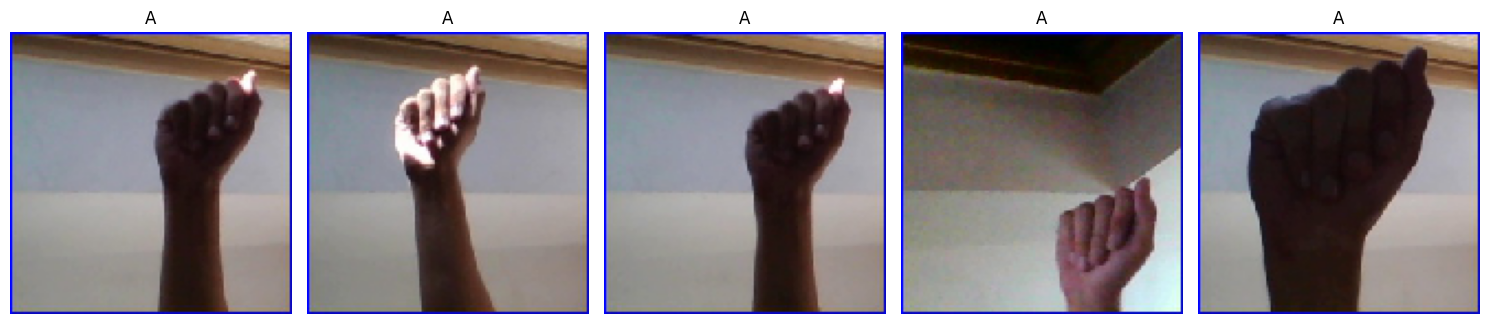

In [6]:
# Generate and visualize augmented images
def show_augmented_images(data_generator, class_name, num_images=5):
    # Find a batch of images for the specific class
    for batch, labels in data_generator:
        # Find the index of the requested class
        class_index = list(data_generator.class_indices.keys()).index(class_name)
        indices = [i for i, label in enumerate(labels) if label[class_index] == 1]

        # Break if enough images are found
        if len(indices) >= num_images:
            break

    # Display augmented images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:num_images]):
        img = batch[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example: Display augmented images for the class "A"
show_augmented_images(train_data, "A")

In [7]:
# Wrapping the DirectoryIterator into a tf.data.Dataset
def make_repeating_dataset(data_iterator):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_iterator,
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(data_iterator.class_indices)), dtype=tf.float32)
        )
    )
    return dataset.repeat()

# Create repeating datasets
train_dataset = make_repeating_dataset(train_data)
val_dataset = make_repeating_dataset(val_data)

In [8]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Convolutional layers
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),

        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # Flatten the output
        Flatten(),
        Dropout(0.2),
        # Fully connected layers
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

In [9]:
# Model parameters
input_shape = (128, 128, 3)  # Image dimensions (H, W, Channels)
num_classes = len(train_data.class_indices)  # Number of classes
# adam = Adam(0.01)
# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

/opt/anaconda3/envs/my-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,509,146 (257.53 MB)

 Trainable params: 67,508,250 (257.52 MB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs with no improvement to wait
    restore_best_weights=True # Restore model weights from the best epoch
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,  # You can adjust this based on your dataset
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping],
    shuffle=True,
    verbose=1
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 779s 499ms/step - accuracy: 0.1924 - loss: 4.8334 - val_accuracy: 0.3383 - val_loss: 2.1784
Epoch 2/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 774s 496ms/step - accuracy: 0.5243 - loss: 1.4030 - val_accuracy: 0.3830 - val_loss: 2.1614
Epoch 3/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 776s 497ms/step - accuracy: 0.7297 - loss: 0.8012 - val_accuracy: 0.5928 - val_loss: 1.3824
Epoch 4/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 800s 513ms/step - accuracy: 0.8442 - loss: 0.4683 - val_accuracy: 0.5417 - val_loss: 1.5987
Epoch 5/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 822s 527ms/step - accuracy: 0.9031 - loss: 0.2971 - val_accuracy: 0.5087 - val_loss: 3.1111
Epoch 6/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 891s 571ms/step - accuracy: 0.9270 - loss: 0.2283 - val_accuracy: 0.6487 - val_loss: 1.3976


/opt/anaconda3/envs/my-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


488/488 ━━━━━━━━━━━━━━━━━━━━ 52s 107ms/step - accuracy: 0.8405 - loss: 0.5087
Test Loss: 0.5531, Test Accuracy: 0.8235


In [12]:
import pickle
model.save('model_no_augmentation.h5')


with open('history_no_augmentation.pkl', 'wb') as f:
    pickle.dump(history.history, f)

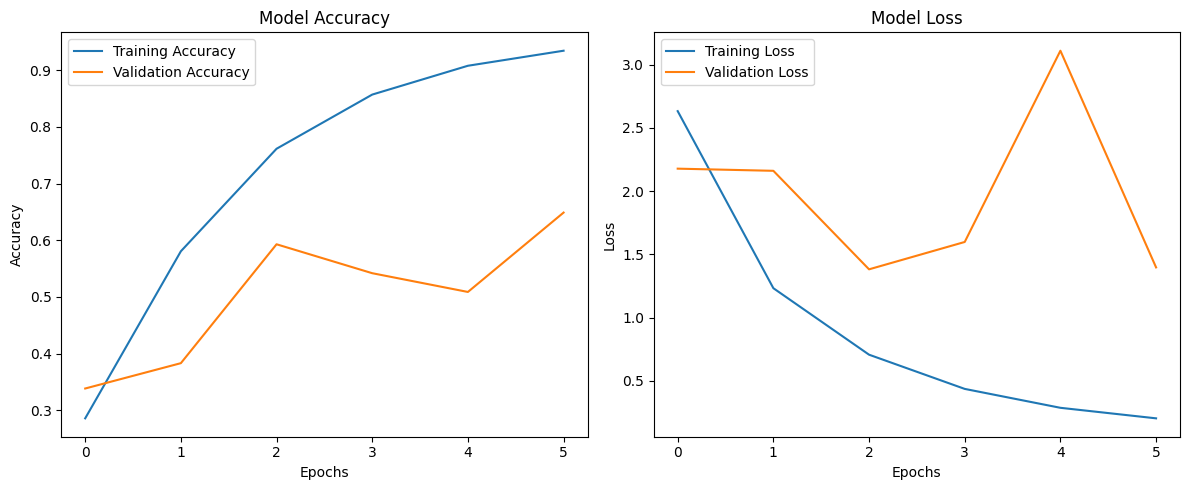

In [13]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_accuracy_loss(history)


488/488 ━━━━━━━━━━━━━━━━━━━━ 108s 220ms/step


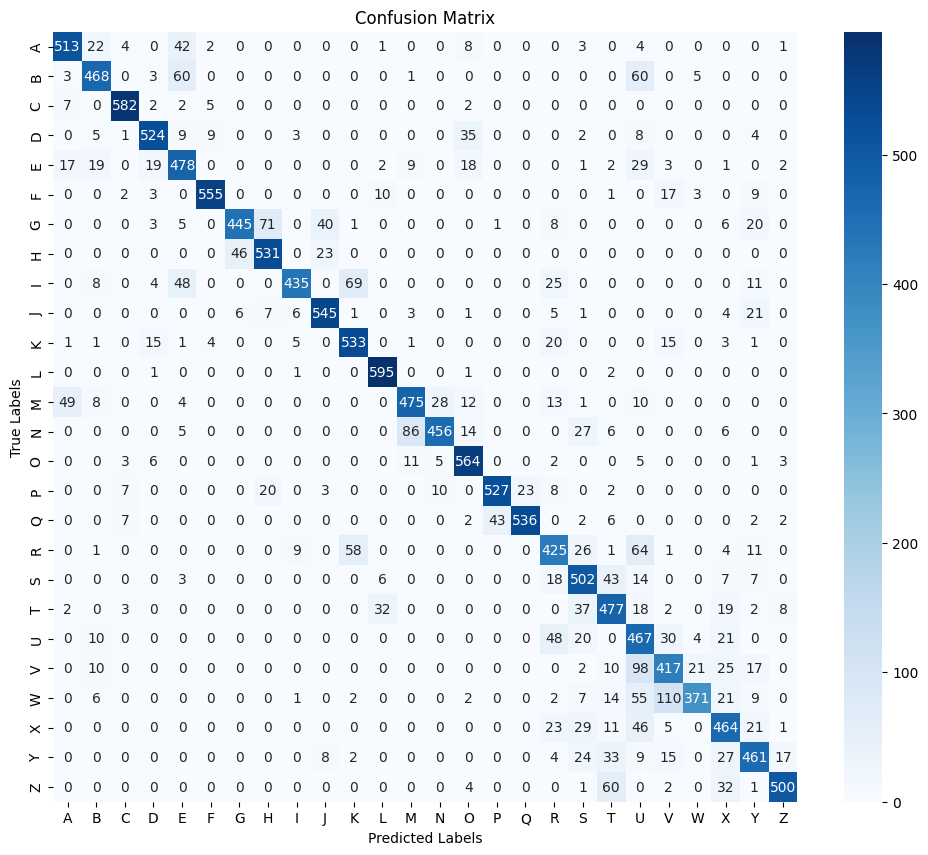


Classification Report:

              precision    recall  f1-score   support

           A       0.87      0.85      0.86       600
           B       0.84      0.78      0.81       600
           C       0.96      0.97      0.96       600
           D       0.90      0.87      0.89       600
           E       0.73      0.80      0.76       600
           F       0.97      0.93      0.94       600
           G       0.90      0.74      0.81       600
           H       0.84      0.89      0.86       600
           I       0.95      0.72      0.82       600
           J       0.88      0.91      0.89       600
           K       0.80      0.89      0.84       600
           L       0.92      0.99      0.96       600
           M       0.81      0.79      0.80       600
           N       0.91      0.76      0.83       600
           O       0.85      0.94      0.89       600
           P       0.92      0.88      0.90       600
           Q       0.96      0.89      0.92       600
  

In [14]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_data):
    # Get true labels and predictions
    true_labels = test_data.classes
    pred_probs = model.predict(test_data)
    pred_labels = np.argmax(pred_probs, axis=1)

    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    class_names = list(test_data.class_indices.keys())

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

# Call the function after training
plot_confusion_matrix(model, test_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


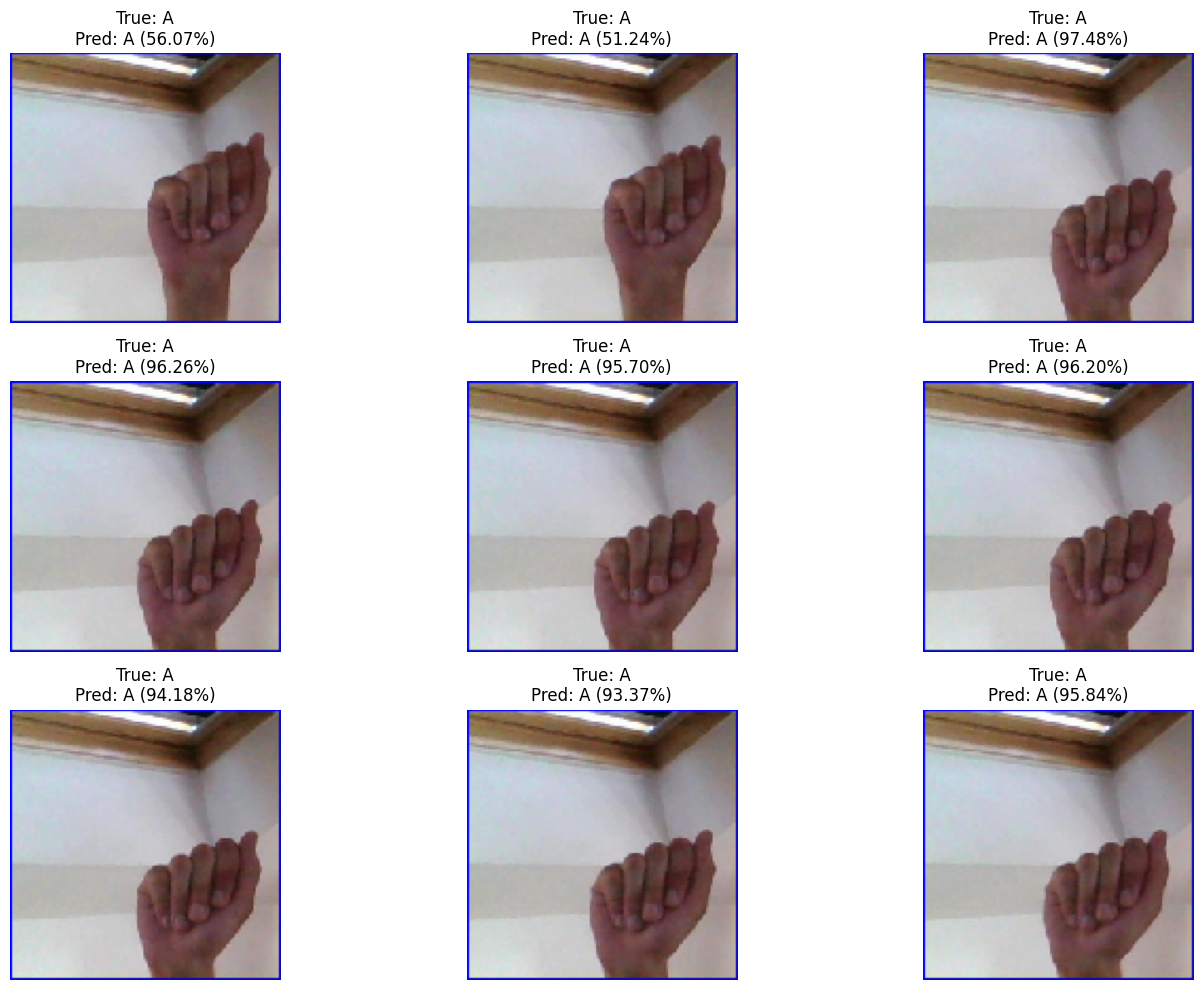

In [15]:
def plot_predictions(model, test_data, num_images=9):
    # Get a batch of test data
    test_data.reset()  # Reset iterator to avoid issues
    images, labels = next(test_data)
    predictions = model.predict(images)

    # Plot predictions
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = list(test_data.class_indices.keys())[np.argmax(labels[i])]
        pred_label = list(test_data.class_indices.keys())[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f}%)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_predictions(model, test_data)


488/488 ━━━━━━━━━━━━━━━━━━━━ 68s 139ms/step


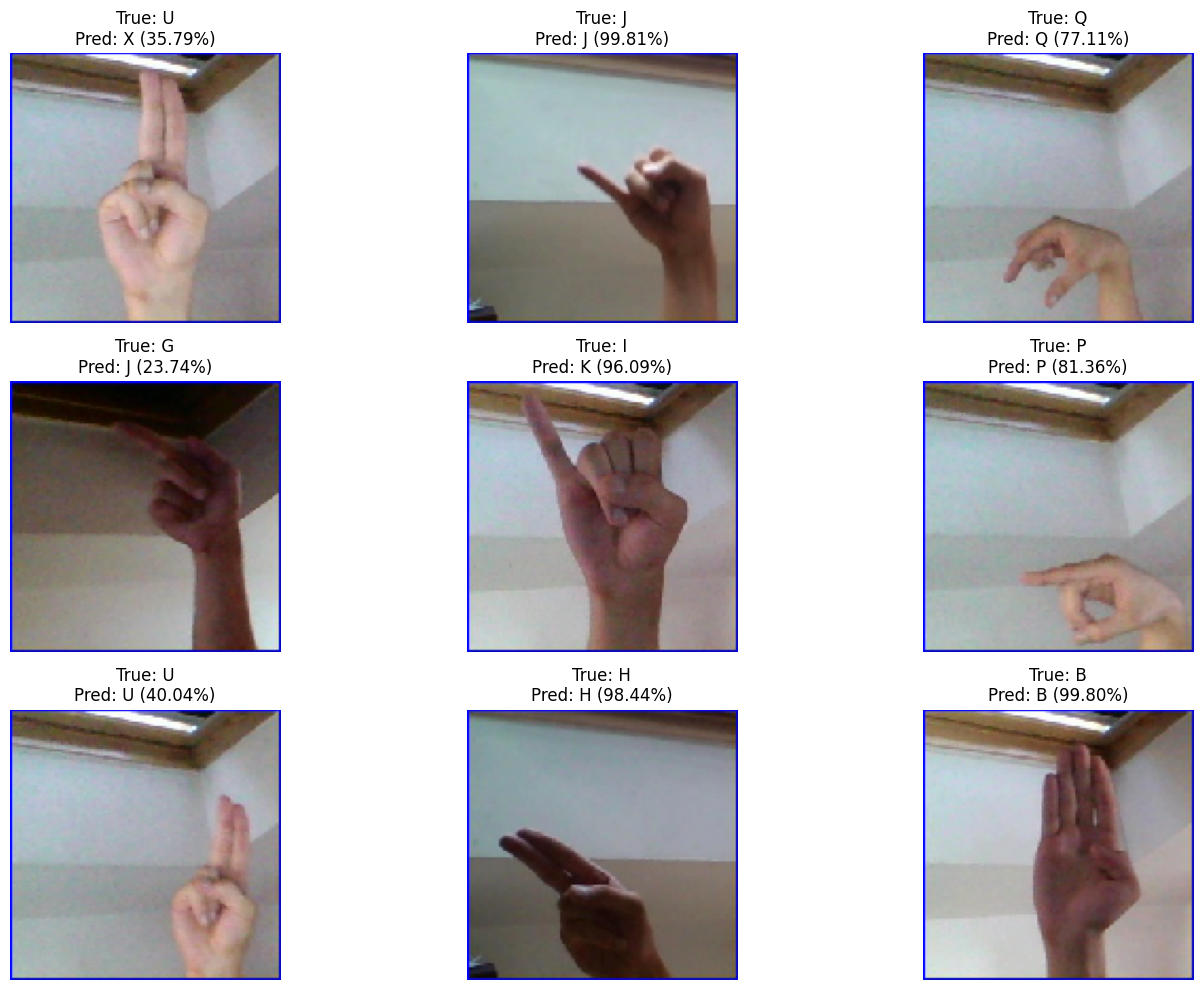

In [16]:
import numpy as np

def plot_random_predictions(model, test_data, num_images=9):
    # Reset test data iterator and fetch all batches
    test_data.reset()
    all_images, all_labels = [], []
    for _ in range(len(test_data)):
        images, labels = next(test_data)
        all_images.append(images)
        all_labels.append(labels)

    # Concatenate all images and labels
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Make predictions on all images
    predictions = model.predict(all_images)

    # Select random indices
    random_indices = np.random.choice(len(all_images), num_images, replace=False)

    # Plot predictions
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(all_images[idx])
        true_label = list(test_data.class_indices.keys())[np.argmax(all_labels[idx])]
        pred_label = list(test_data.class_indices.keys())[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx]) * 100
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f}%)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_random_predictions(model, test_data)


488/488 ━━━━━━━━━━━━━━━━━━━━ 114s 233ms/step


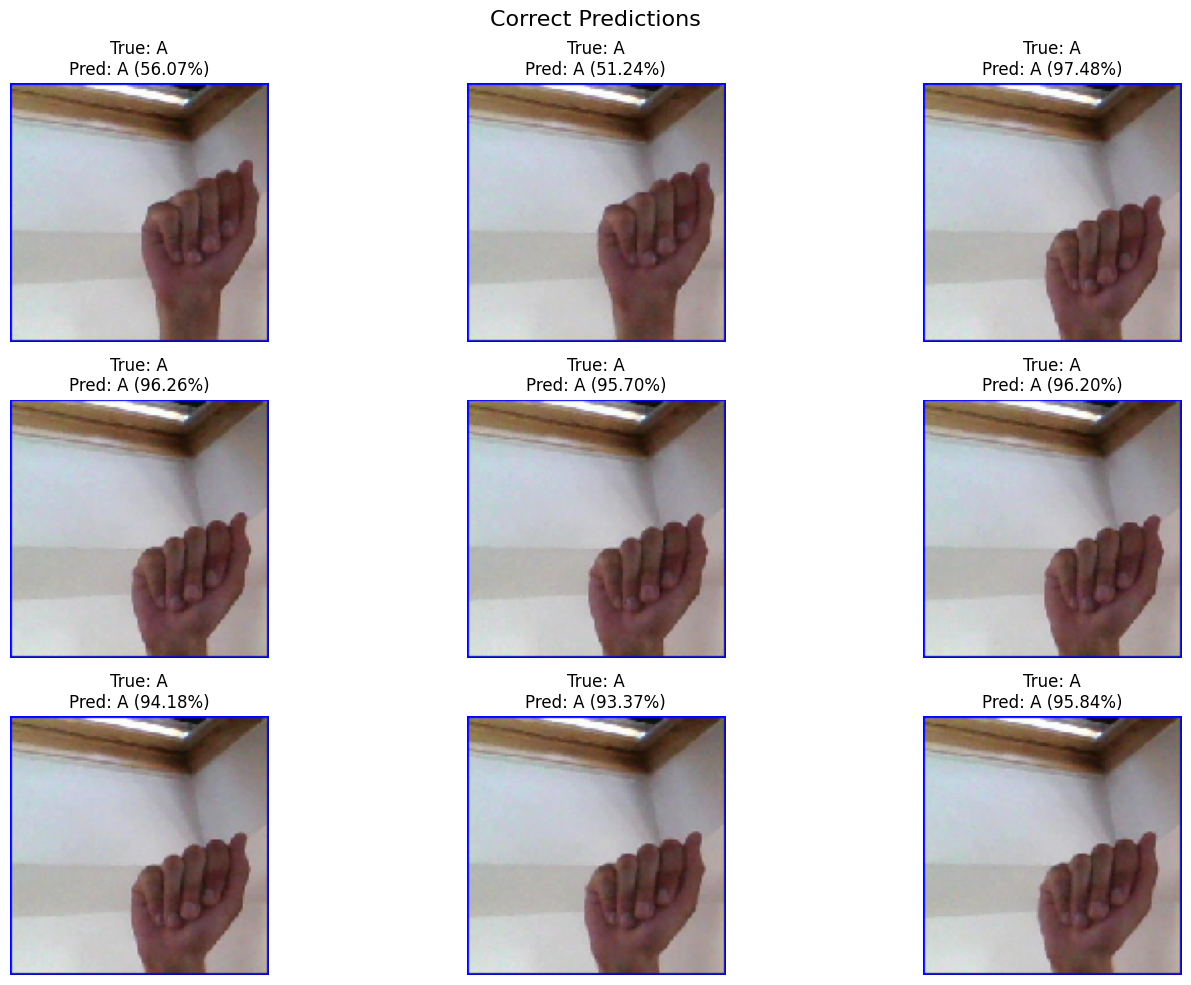

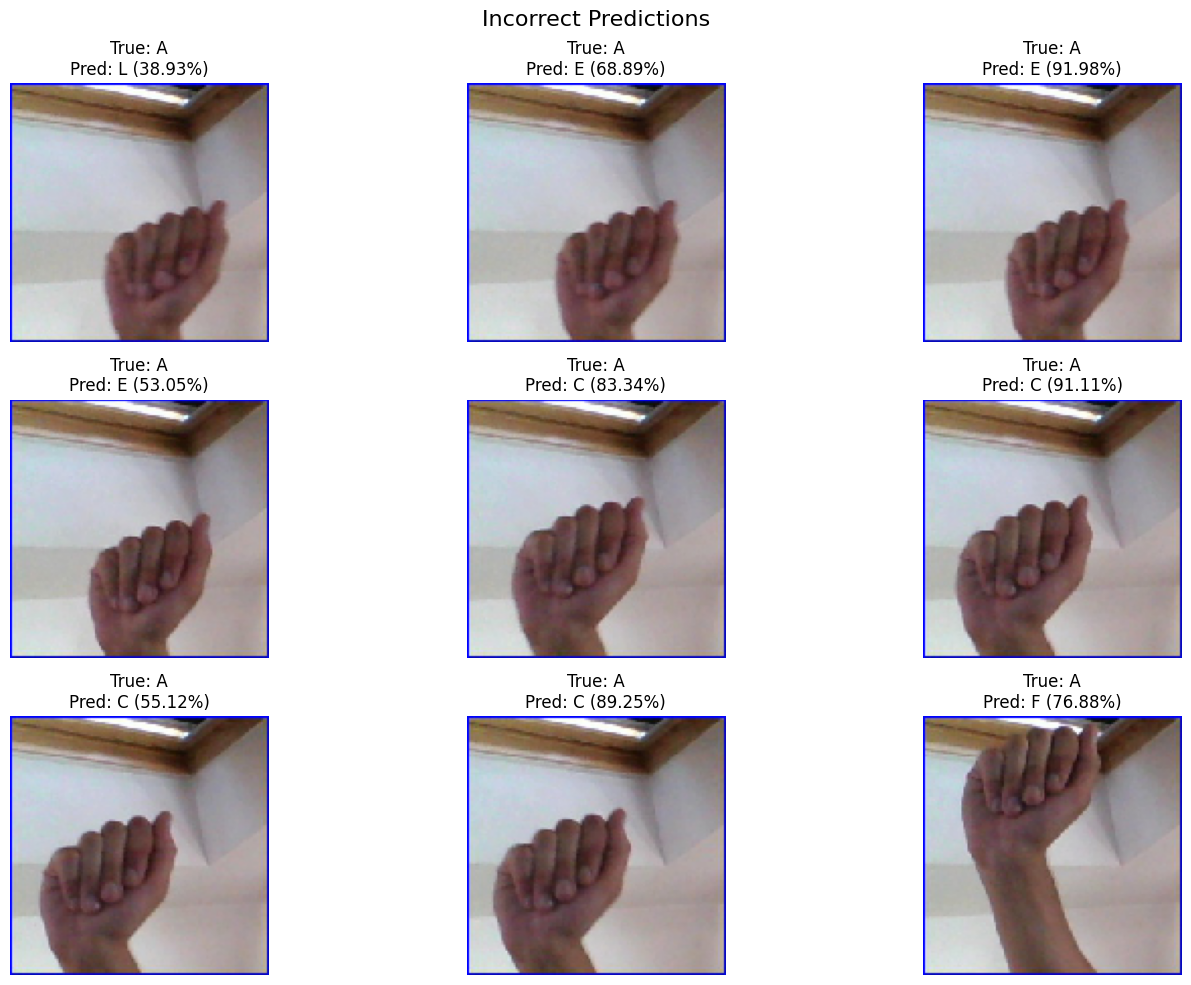

In [17]:
def plot_correct_and_incorrect_predictions(model, test_data, num_images=9):
    # Reset test data iterator and fetch all data
    test_data.reset()
    all_images, all_labels = [], []
    for _ in range(len(test_data)):
        images, labels = next(test_data)
        all_images.append(images)
        all_labels.append(labels)

    # Concatenate all images and labels
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Make predictions
    predictions = model.predict(all_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(all_labels, axis=1)

    # Separate correct and incorrect predictions
    correct_indices = [i for i in range(len(true_labels)) if predicted_labels[i] == true_labels[i]]
    incorrect_indices = [i for i in range(len(true_labels)) if predicted_labels[i] != true_labels[i]]

    # Helper function to plot images
    def plot_images(indices, title):
        plt.figure(figsize=(15, 10))
        for i, idx in enumerate(indices[:num_images]):
            plt.subplot(3, 3, i + 1)
            plt.imshow(all_images[idx])
            true_label = list(test_data.class_indices.keys())[true_labels[idx]]
            pred_label = list(test_data.class_indices.keys())[predicted_labels[idx]]
            confidence = np.max(predictions[idx]) * 100
            plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f}%)")
            plt.axis('off')
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

    # Plot correct predictions
    if correct_indices:
        plot_images(correct_indices, "Correct Predictions")
    else:
        print("No correct predictions found.")

    # Plot incorrect predictions
    if incorrect_indices:
        plot_images(incorrect_indices, "Incorrect Predictions")
    else:
        print("No incorrect predictions found.")

# Call the function
plot_correct_and_incorrect_predictions(model, test_data)


In [22]:
from tensorflow.keras.utils import plot_model

# Save the model diagram as an image
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.
